In [1]:
import numpy as np
from matplotlib import ticker,patches,pyplot as plt
import read_params
from dbyd2 import dbyd2
from scipy.special import j1,j0,jn
from scipy import interpolate,fftpack
from astropy.io import fits
from astropy.constants import R_sun
from astropy import units

def j2(x): return jn(2,x)
def j1prime(x): return 0.5*(j0(x)-j2(x))

Lx=read_params.get_xlength() * units.Mm
nx=read_params.get_nx()
x=np.linspace(-Lx/2,Lx/2,nx,endpoint=False)

z,c,rho=np.loadtxt(read_params.get_solarmodel(),usecols=[0,1,2],unpack=True)
c *= units.cm/units.s
Rsun = R_sun.to("cm")
z=(z-1)*Rsun

dz = dbyd2(np.atleast_2d(z),1).T

def ddz(arr):
    # always returns 2D
    if len(arr.shape) == 1:
        return dbyd2(np.atleast_2d(arr),1).T / dz
    # assume f(z,x), derivative along first axis
    elif len(arr.shape) == 2:
        return dbyd2(arr,1) / dz
    
dzlnrho = ddz(np.log(rho)).squeeze() / units.Mm

In [2]:
# Dimensional model parameters

v0 = 240 * units.m/units.s
R = 15 * units.Mm
k = 2*np.pi/(2*R)
z0 = -2.3 * units.Mm
sigmaz = 0.912 * units.Mm

We define 
$$
u\left(z\right) = \frac{v_{0}}{k\,c\left(z\right)}e^{-\left(z-z_{0}\right)^{2}/2\sigma_{z}^{2}}
$$

The stream function is given by 

$$
\psi(x,z) = u(z)\,\mathrm{sign}\left(x\right)\,\exp\left(-\left|x\right|/R\right)\,J_{1} \left(k\left|x\right|\right)
$$

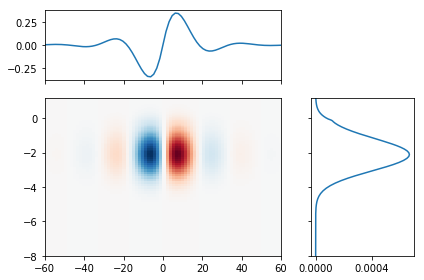

In [3]:
u = v0/k*np.exp(-(z-z0)**2/(2*sigmaz**2))/c
u = u[:,np.newaxis]

hx = np.sign(x)*np.exp(-np.abs(x)/R)*j1(k*np.abs(x))
psi = u*hx

ax1 = plt.subplot2grid((3,3),(0,0),colspan=2)
ax1.plot(x.to("Mm").value,hx)
ax1.set_xlim(-4*R.to("Mm").value,4*R.to("Mm").value)
ax1.xaxis.set_major_formatter(ticker.NullFormatter())

ax3 = plt.subplot2grid((3,3),(1,2),rowspan=2)
ax3.plot(u,z.to("Mm").value)
ax3.set_ylim(-8,z[-1].to("Mm").value)
ax3.yaxis.set_major_formatter(ticker.NullFormatter())
ax3.xaxis.set_major_locator(ticker.MaxNLocator(2))

ax2 = plt.subplot2grid((3,3),(1,0),colspan=2,rowspan=2)
plt.pcolormesh(x.to("Mm"),z.to("Mm"),psi.to("Mm"),cmap="RdBu_r")
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax3.get_ylim())

plt.tight_layout()

We compute velocity as 

$$
\begin{eqnarray*}
\mathbf{v} & = & \frac{1}{\rho}\nabla\times\left(\rho c\psi\mathbf{e}_{y}\right)\\
v_{x} & = & -\frac{1}{\rho}\partial_{z}\left(\rho c\psi\right)=-\frac{1}{\rho}\partial_{z}\left(\rho cu\right)h_{x}\\
 & = & -ch_{x}\left[\frac{1}{c}\partial_{z}\left(cu\right)+\partial_{z}\left(\ln\rho\right)u\right]\\
 & = & c\left[\frac{\left(z-z_{0}\right)}{\sigma_{z}^{2}}-\partial_{z}\left(\ln\rho\right)\right]\psi\\
v_{z} & = & c\partial_{x}\psi=cu\partial_{x}h_{x}\\
 & = & cu\partial_{x}\left(\exp\left(-\left|x\right|/R\right)J_{1}\left(k\left|x\right|\right)\mathrm{sign}\left(x\right)\right)\\
 & = & cuk\left[J_{1}^{\prime}\left(k\left|x\right|\right)-\frac{1}{kR}J_{1}\left(k\left|x\right|\right)\right]\exp\left(-\left|x\right|/R\right)
\end{eqnarray*}
$$

In [4]:
vx = (c*((z-z0)/sigmaz**2 - dzlnrho))[:,None]*psi
vz = c[:,None]*u*k*(j1prime(k*np.abs(x)) - 1/(k*R)*j1(k*np.abs(x)))*np.exp(-np.abs(x)/R)

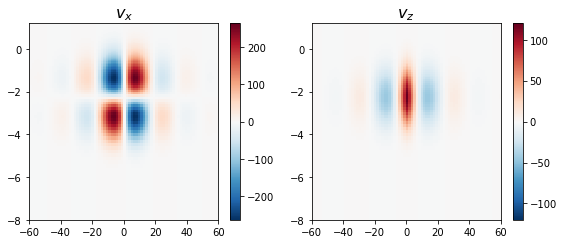

In [5]:
ax1=plt.subplot(121)
vmax = abs(vx.to("m/s")).max().value
plt.pcolormesh(x.to("Mm"),z.to("Mm"),vx.to("m/s"),cmap="RdBu_r",vmin=-vmax,vmax=vmax)
plt.colorbar()

ax2=plt.subplot(122,sharex=ax1,sharey=ax1)
vmax = abs(vz.to("m/s")).max().value
plt.pcolormesh(x.to("Mm"),z.to("Mm"),vz.to("m/s"),cmap="RdBu_r",vmin=-vmax,vmax=vmax)
plt.colorbar()

ax1.set_xlim(-4*R.to("Mm").value,4*R.to("Mm").value)
ax1.set_ylim(-8,z[-1].to("Mm").value)

ax1.set_title("$v_x$",fontsize=16);
ax2.set_title("$v_z$",fontsize=16);

plt.gcf().set_size_inches(8,3.5)
plt.tight_layout()

In [6]:
fits.writeto("true_psi.fits",psi.to("Mm").value,overwrite=True)
fits.writeto("true_vx.fits",vx.to("m/s").value,overwrite=True)
fits.writeto("true_vz.fits",vz.to("m/s").value,overwrite=True)